In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
class KMeansClustering(object):
    """Initializes `KMeansClustering` class instance.

    Attributes:
        num_dims: int, number of dimensions of input points.
        num_clusters: int, number of clusters to assign points to.
        max_iterations: int, maximum number of iterations to attempt
            convergence before exiting loop.
        centroid_initialization_method: str, the centroid initialization
            method to use.
        points: tensor, rank 2 tensor of shape (num_points, num_dims) that
            contains the coordinates of each point.
        points_expanded: tensor, rank 3 tensor of shape
            (1, num_points, num_dims) that enables broadcast subtraction of
            point coordinates with centroids.
        centroids: tf.Variable, rank 2 Variable of shape
            (num_clusters, num_dims) that contains the coordinates for each
            cluster centroid.
        assignments: tf.Variable, rank 1 Variable of shape (num_points,) that
            contains the cluster index assignment for each point.
        loss: tensor, rank 0 tensor of shape () that represents the current
            loss of the point assignment and centroid placement.
        best_loss: tensor, rank 0 tensor of shape () that represents the best
            loss of the point assignment and centroid placement.
    """
    def __init__(
        self,
        num_clusters,
        num_dims,
        max_iterations,
        centroid_initialization_method
    ):
        """Initializes `KMeansClustering` class instance.

        Args:
            num_clusters: int, number of clusters to assign points to.
            num_dims: int, number of dimensions of input points.
            max_iterations: int, maximum number of iterations to attempt
                convergence before exiting loop.
            centroid_initialization_method: str, the centroid initialization
                method to use.
        """
        self.num_clusters = num_clusters
        self.num_dims = num_dims
        self.max_iterations = max_iterations
        self.centroid_initialization_method = centroid_initialization_method

        self.points = None
        self.points_expanded = None

        self.centroids = tf.Variable(
            initial_value=tf.zeros(
                shape=(self.num_clusters, self.num_dims), dtype=tf.float32
            ),
            trainable=False
        )

        self.assignments = None

        self.loss = tf.zeros(shape=[], dtype=tf.float32)
        self.best_loss = tf.ones(shape=[], dtype=tf.float32) * tf.float32.max

    def assign_assignments(self, new_assignments):
        """Assigns new point centroid assignments.

        Args:
            new_assignments: tensor, rank 1 tensor of shape (batch_size,) that
                contains the centroid index assignments for each point.
        """
        self.assignments = new_assignments

    def find_closest_centroid_assignments(self):
        """Finds closest centroids for point assignments.
        """
        # Expand centroids to be able to do broadcast subtraction.
        self.centroids_expanded = tf.expand_dims(input=self.centroids, axis=1)

        # Calculate distances from points and centroids.
        distances = tf.math.reduce_sum(
            input_tensor=tf.square(
                x=self.points_expanded - self.centroids_expanded
            ),
            axis=2
        )

        # Assign points to closest centroid.
        self.assign_assignments(
            new_assignments=tf.math.argmin(input=distances, axis=0)
        )

        # Calculate loss using minimum euclidean distance.
        min_distances = tf.reduce_min(input_tensor=distances, axis=0)

        self.loss = tf.reduce_sum(input_tensor=min_distances)

    @tf.function
    def assign_centroids(self, new_centroids):
        """Assigns new centroid coordinates to centroids variable.

        Args:
            new_centroids: tensor, rank 2 tensor that contains the coordinates
                for each n-dimensional centroid.
        """
        self.centroids.assign(value=new_centroids)

    def compute_centroids(self):
        """Computes updated centroid coordinates.
        """
        means = []
        # Loop through all clusters.
        for cluster_idx in range(self.num_clusters):
            # Find indices for points assigned to this cluster.
            # shape = (num_points_assigned, 1)
            cluster_assignment_indices = tf.where(
                tf.equal(
                    x=self.assignments, y=cluster_idx
                )
            )

            # Gather assigned points to cluster.
            # shape = (1, num_points_assigned, num_dims)
            cluster_assigned_points = tf.gather(
                params=self.points,
                indices=tf.reshape(
                    tensor=cluster_assignment_indices,
                    shape=[1, -1]
                )
            )

            # Get cluster mean values for each dimension.
            # shape = (1, num_dims)
            cluster_mean = tf.math.reduce_mean(
                cluster_assigned_points,
                axis=1
            )

            # Append mean to list for concatenation after the loop.
            means.append(cluster_mean)

        self.assign_centroids(new_centroids=tf.concat(values=means, axis=0))

    def centroid_initialization(self, method):
        """Initializes centroids via chosen method.

        Args:
            method: str, the centroid initialization method to use.
        """
        if method == "random_points":
            return tf.slice(
                input_=tf.random.shuffle(value=self.points),
                begin=[0, 0],
                size=[self.num_clusters, -1]
            )
        elif method == "kmeans++":
            # Seed with first point.
            centroids = [self.points[0]]

            for _ in range(1, self.num_clusters):
                dist_sq = tf.concat(
                    values=[
                        tf.reduce_min(
                            input_tensor=tf.concat(
                                values=[
                                    tf.tensordot(
                                        a=c - x, b=c - x, axes=(-1, -1)
                                    )
                                    for c in centroids
                                ],
                                axis=0
                            )
                        )
                        for x in self.points
                    ],
                    axis=0
                )

                probs = dist_sq / tf.reduce_sum(dist_sq)
                cumulative_probs = tf.math.cumsum(x=probs)
                r = tf.random.uniform(
                    shape=(), minval=0., maxval=1.0, dtype=tf.float32
                )

                for j, p in enumerate(cumulative_probs):
                    if r < p:
                        i = j
                        break

                centroids.append(self.points[i])

            return tf.stack(values=centroids, axis=0)

        elif method == "random_space":
            return tf.random.uniform(
                shape=(self.num_clusters, self.num_dims),
                minval=-1.,
                maxval=1.,
                dtype=tf.float32
            )
        else:
            return self.centroid_initialization(self, method="random_space")

    def kmeans_clustering(self, points, print_iteration_info):
        """Performs kmeans clustering until convergence.

        Args:
            points: tensor, rank 2 tensor of shape (num_points, num_dims) that
                contains the coordinates of each point.
            print_iteration_info: bool, whether to print iterations or not.
        """
        self.points = points

        if self.points.shape[0] <= self.num_clusters:
            if self.points.shape[0] < self.num_clusters:
                print(
                    "There are less points than requested number of clusters!"
                )
            elif self.points.shape[0] == self.num_clusters:
                print("Every point gets its own cluster!")

            padding = tf.zeros(
                shape=(
                    self.num_clusters - self.points.shape[0],
                    self.num_dims
                ),
                dtype=tf.float32
            )

            self.assign_centroids(
                new_centroids=tf.concat(
                    values=[self.points, padding], axis=0
                )
            )

            self.assign_assignments(
                new_assignments=tf.range(
                    start=0, limit=self.points.shape[0], dtype=tf.int64
                )
            )

            self.best_loss = tf.zeros(shape=(), dtype=tf.float32)
            return

        # Expand points to be able to do broadcast subtraction.
        self.points_expanded = tf.expand_dims(input=self.points, axis=0)

        # Reset state.
        self.assign_centroids(
            new_centroids=self.centroid_initialization(
                method=self.centroid_initialization_method
            )
        )

        self.assign_assignments(
            new_assignments=tf.zeros(
                shape=self.points.shape[0], dtype=tf.int64
            )
        )

        self.best_loss = tf.ones(shape=[], dtype=tf.float32) * tf.float32.max

        # Perform iterations until convergence.
        for iteration in range(self.max_iterations):
            # Find closest centroid assignments for points.
            self.find_closest_centroid_assignments()

            if print_iteration_info:
                print("Iteration {} has {} loss.".format(iteration, self.loss))

            # Break early if system has converged.
            if self.loss >= self.best_loss:
                return
            self.compute_centroids()

            # Update loss.
            self.best_loss = self.loss

        # Perform final centroid assignment for points.
        self.find_closest_centroid_assignments()


In [3]:
class OptimalKMeansClustering(object):
    """Initializes `OptimalKMeansClustering` class instance.

    Attributes:
        points: tensor, rank 2 tensor of shape (num_points, num_dims) that
            contains the coordinates of each point in real dataset.
        num_points: int, number of input points to cluster.
        num_dims: int, number of dimensions of input points.
        max_clusters: int, max number of clusters to assign points to.
        max_iterations: int, maximum number of iterations to attempt
            convergence before exiting loop.
        centroid_initialization_method: str, the centroid initialization
            method to use.
        num_reference_datasets: int, number of reference datasets to cluster
            and take the expectation over.
        min_bounds: tensor, rank 1 tensor of shape (num_dims,) containing the
            minimum point values along each dimension.
        max_bounds: tensor, rank 1 tensor of shape (num_dims,) containing the
            maximum point values along each dimension.
        kmeans_real_models: list, instances of `KMeansClustering` using real
            points data for each number of clusters.
        kmeans_reference_models: list, instances of `KMeansClustering` using
            reference points data for each number of clusters.
        reference_points: tensor, rank 2 tensor of shape (num_points, num_dims)
            that contains the coordinates of each point in reference dataset.
        best_model: instance of `KMeansClustering`, best model using optimal
            gap statistic's value for k.
    """
    def __init__(
        self,
        points,
        max_clusters,
        max_iterations,
        centroid_initialization_method,
        num_reference_datasets
    ):
        """Initializes `KMeansClustering` class instance.

        Args:
            points: tensor, rank 2 tensor of shape (num_points, num_dims) that
                contains the coordinates of each point.
            max_clusters: int, max number of clusters to assign points to.
            max_iterations: int, maximum number of iterations to attempt
                convergence before exiting loop.
            centroid_initialization_method: str, the centroid initialization
                method to use.
            num_reference_datasets: int, number of reference datasets to
                cluster and take the expectation over.
        """
        self.points = points
        self.num_points = points.shape[0]
        self.num_dims = points.shape[1]
        self.max_clusters = max_clusters
        self.centroid_initialization_method = centroid_initialization_method
        self.max_iterations = max_iterations
        self.num_reference_datasets = num_reference_datasets

        self.min_bounds, self.max_bounds = self.calculate_point_bounding_box()

        self.kmeans_real_models = [
            KMeansClustering(
                num_clusters=k,
                num_dims=self.num_dims,
                max_iterations=self.max_iterations,
                centroid_initialization_method=(
                    self.centroid_initialization_method
                )
            )
            for k in range(1, self.max_clusters + 1)
        ]

        self.kmeans_reference_models = [
            KMeansClustering(
                num_clusters=k,
                num_dims=self.num_dims,
                max_iterations=self.max_iterations,
                centroid_initialization_method=(
                    self.centroid_initialization_method
                )
            )
            for k in range(1, self.max_clusters + 1)
        ]

        self.reference_points = tf.zeros_like(
            input=self.points, dtype=tf.float32
        )

        self.best_model = None

    def calculate_point_bounding_box(self):
        """Calculates bounding box around points.
        """
        return (
            tf.reduce_min(input_tensor=self.points, axis=0),
            tf.reduce_max(input_tensor=self.points, axis=0)
        )

    def create_reference_dataset(self):
        """Creates reference dataset within bounds.
        """
        self.reference_points = tf.random.uniform(
            shape=self.points.shape,
            minval=self.min_bounds,
            maxval=self.max_bounds,
            dtype=tf.float32
        )

    def gap_statistic(self, logWks, expected_logWkbs, sk, k):
        """Calculates gap statistics between real and reference datasets.

        Args:
            logWks: list, contains the log of the real data error measures.
            expected_logWkbs: list, contains the log of the expectation of the
                reference data error measures.
            sk: list, contains the reference distribution sampling errors.
            k: int, current number of clusters.

        Returns:
            Float gap statistic difference between k and k + 1.
        """
        # Perform kmeans on real points.
        print("Performing kmeans on real points!")
        self.kmeans_real_models[k - 1].kmeans_clustering(
            points=self.points, print_iteration_info=True
        )
        logWks[k - 1] = np.log(self.kmeans_real_models[k - 1].best_loss)

        logBWkbs = [0.] * self.num_reference_datasets
        print("Performing kmeans on reference points!")
        for i in range(self.num_reference_datasets):
            self.create_reference_dataset()

            self.kmeans_reference_models[k - 1].kmeans_clustering(
                points=self.reference_points, print_iteration_info=False
            )

            logBWkbs[i] = np.log(self.kmeans_reference_models[k - 1].best_loss)
        expected_logWkbs[k - 1] = sum(logBWkbs) / self.num_reference_datasets

        sq_diff = (logBWkbs - expected_logWkbs[k - 1]) ** 2
        sd = np.sqrt(sum(sq_diff / self.num_reference_datasets))
        sk[k - 1] = sd * np.sqrt(1. + 1. / self.num_reference_datasets)

        if k > 1:
            gap_k = expected_logWkbs[k - 2] - logWks[k - 2]
            gap_k_plus_1 = expected_logWkbs[k - 1] - logWks[k - 1]
            gap_diff = gap_k - (gap_k_plus_1 - sk[k - 1])
            return gap_diff
        return -1.

    def find_optimal_k(self):
        """Finds optimal k for kmeans clustering.
        """
        self.calculate_point_bounding_box()

        logWks = [0.] * self.max_clusters
        expected_logWkbs = [0.] * self.max_clusters
        sk = [0.] * self.max_clusters

        for k in range(1, self.max_clusters + 1):
            print("\nk = {}".format(k))
            gap_diff = self.gap_statistic(logWks, expected_logWkbs, sk, k)
            if gap_diff >= 0.:
                print("The optimal value for k is {}.".format(k))
                self.best_model = self.kmeans_real_models[k - 1]
                return
        print("The optimal value for k is {}.".format(1))
        self.best_model = self.kmeans_real_models[0]


In [4]:
def create_gaussian_clusters(
    num_points,
    num_dims,
    num_clusters,
    min_bounds,
    max_bounds,
    min_sds,
    max_sds
):
    """Creates synthetic gaussian distributed cluster data.

    Args:
        num_points: int, number of points across all clusters.
        num_dims: int, number of dimensions.
        num_clusters: int, number of clusters to create.
        min_bounds: array of floats of shape (num_clusters, num_dims) for
            minimum bounds of points.
        max_bounds: array of floats of shape (num_clusters, num_dims) for
            minimum bounds of points.
        min_sds: array of floats of shape (num_clusters, num_dims) for
            minimum standard deviation of points.
        max_sds: array of floats of shape (num_clusters, num_dims) for
            maximum standard deviation of points.

    Returns:
        Points array of shape (num_points // num_clusters, num_dims).
    """
    n = float(num_points) / num_clusters
    X = []

    for i in range(num_clusters):
        centroids = [
            np.random.uniform(low=min_bounds[i][j], high=max_bounds[i][j])
            for j in range(num_dims)
        ]
        sd = [
            np.random.uniform(low=min_sds[i][j], high=max_sds[i][j])
            for j in range(num_dims)
        ]
        x = []
        while len(x) < n:
            point = []
            while len(point) < num_dims:
                coord = np.random.normal(
                    loc=centroids[len(point)], scale=sd[len(point)]
                )
                # Continue drawing points from distribution within the bounds.
                if (coord >= min_bounds[i][len(point)] and
                    coord <= max_bounds[i][len(point)]
                   ):
                    point.append(coord)
            x.append(point)
        X.extend(x)
    X = np.array(X)[:num_points]

    return X.astype(np.float32)


In [5]:
num_points = 1000
num_dims = 2
num_clusters = 5
min_bounds = np.array(
    [
        [-10., -10.],
        [-10., -10.],
        [-10., -10.],
        [-10., -10.],
        [-10., -10.]
    ]
)
max_bounds = np.array(
    [
        [10., 10.],
        [10., 10.],
        [10., 10.],
        [10., 10.],
        [10., 10.]
    ]
)
min_sds = np.array(
    [
        [0.05, 0.05],
        [0.05, 0.05],
        [0.05, 0.05],
        [0.05, 0.05],
        [0.05, 0.05]
    ]
)
max_sds = np.array(
    [
        [0.5, 0.5],
        [0.2, 0.2],
        [0.5, 0.5],
        [0.5, 0.5],
        [0.5, 0.5]
    ]
)

In [6]:
points = create_gaussian_clusters(
    num_points,
    num_dims,
    num_clusters,
    min_bounds,
    max_bounds,
    min_sds,
    max_sds
)

In [7]:
kmeans = KMeansClustering(
    num_clusters=3,
    num_dims=num_dims,
    max_iterations=10,
    centroid_initialization_method="kmeans++"
)

In [8]:
kmeans.kmeans_clustering(points=points, print_iteration_info=True)

Iteration 0 has 31342.353515625 loss.
Iteration 1 has 18872.97265625 loss.
Iteration 2 has 17319.494140625 loss.
Iteration 3 has 17319.494140625 loss.


In [9]:
kmeans.centroids

<tf.Variable 'Variable:0' shape=(3, 2) dtype=float32, numpy=
array([[-2.9270658 ,  0.5366012 ],
       [ 9.013088  , -0.35756356],
       [ 6.2469273 ,  6.4142084 ]], dtype=float32)>

In [10]:
kmeans.assignments

<tf.Tensor: shape=(1000,), dtype=int64, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    

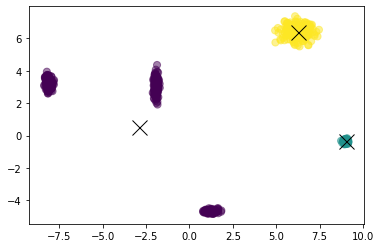

In [11]:
plt.scatter(
    x=points[:, 0],
    y=points[:, 1],
    c=kmeans.assignments.numpy(),
    s=50,
    alpha=0.5
)
plt.plot(
    kmeans.centroids[:, 0].numpy(),
    kmeans.centroids[:, 1].numpy(),
    "kx",
    markersize=15
)
plt.show()

In [12]:
optimal_kmeans = OptimalKMeansClustering(
    points=points,
    max_clusters=10,
    max_iterations=100,
    centroid_initialization_method="kmeans++",
    num_reference_datasets=10
)

In [13]:
optimal_kmeans.find_optimal_k()


k = 1
Performing kmeans on real points!
Iteration 0 has 138751.0625 loss.
Iteration 1 has 50908.86328125 loss.
Iteration 2 has 50908.86328125 loss.
Performing kmeans on reference points!

k = 2
Performing kmeans on real points!
Iteration 0 has 33670.20703125 loss.
Iteration 1 has 22684.21484375 loss.
Iteration 2 has 22684.21484375 loss.
Performing kmeans on reference points!

k = 3
Performing kmeans on real points!
Iteration 0 has 18298.0859375 loss.
Iteration 1 has 9319.822265625 loss.
Iteration 2 has 9319.822265625 loss.
Performing kmeans on reference points!

k = 4
Performing kmeans on real points!
Iteration 0 has 7497.31884765625 loss.
Iteration 1 has 3968.96875 loss.
Iteration 2 has 3968.96875 loss.
Performing kmeans on reference points!

k = 5
Performing kmeans on real points!
Iteration 0 has 11196.10546875 loss.
Iteration 1 has 2652.942626953125 loss.
Iteration 2 has 131.63360595703125 loss.
Iteration 3 has 131.63360595703125 loss.
Performing kmeans on reference points!

k = 6


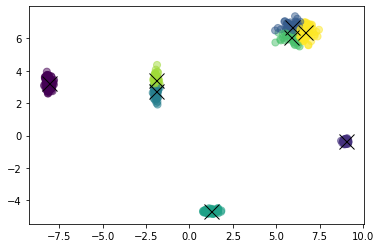

In [14]:
plt.scatter(
    x=points[:, 0],
    y=points[:, 1],
    c=optimal_kmeans.best_model.assignments.numpy(),
    s=50,
    alpha=0.5
)
plt.plot(
    optimal_kmeans.best_model.centroids[:, 0].numpy(),
    optimal_kmeans.best_model.centroids[:, 1].numpy(),
    "kx",
    markersize=15
)
plt.show()